## Importing libraries

In [2]:
import sys
sys.path.append('../') 
from imports import *
import cudf
import cupy as cp
from sklearn.utils import resample

ModuleNotFoundError: No module named 'cudf'

In [2]:
def plot_roc_pr_curves(y_true, y_probs, n_bootstraps=1000):
    """Perform bootstrapping to calculate the confidence intervals and plot the ROC and PR curves"""
    bootstrap_auroc_scores = []
    bootstrap_average_precision_scores = []

    for _ in range(n_bootstraps):
        # Bootstrap sample (with replacement)
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_boot = y_true[indices]
        y_probs_boot = y_probs[indices]

        # Compute metrics for bootstrap sample
        bootstrap_auroc_scores.append(roc_auc_score(y_true_boot, y_probs_boot))
        bootstrap_average_precision_scores.append(average_precision_score(y_true_boot, y_probs_boot))

    # Compute confidence intervals
    auroc_lower = np.percentile(bootstrap_auroc_scores, 2.5)
    auroc_upper = np.percentile(bootstrap_auroc_scores, 97.5)
    ap_lower = np.percentile(bootstrap_average_precision_scores, 2.5)
    ap_upper = np.percentile(bootstrap_average_precision_scores, 97.5)

    # Calculate original ROC and PR curves
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auroc = roc_auc_score(y_true, y_probs)
    average_precision = average_precision_score(y_true, y_probs)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower:.2f}, {auroc_upper:.2f}]')

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {average_precision:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower:.2f}, {ap_upper:.2f}]')

    plt.show()

    # Return the confidence intervals
    return (auroc_lower, auroc_upper), (ap_lower, ap_upper)




## Loading the pre-processed saved datasets

In [3]:
# loading processed data
df_train = pd.read_csv('./uci-adult-processed-data/train.csv')
df_val = pd.read_csv('./uci-adult-processed-data/val.csv')
df_test = pd.read_csv('./uci-adult-processed-data/test.csv')

# Define your features and target variable
target_column = 'target' 
features = df_train.columns.drop(target_column)

# Separate features and target and convert to NumPy arrays
X_train = df_train[features].to_numpy()
y_train = df_train[target_column].to_numpy()
X_val = df_val[features].to_numpy()
y_val = df_val[target_column].to_numpy()
X_test = df_test[features].to_numpy()
y_test = df_test[target_column].to_numpy()

In [4]:
# Initialize and fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)  
log_reg.fit(X_train, y_train)

# Predict on validation set
y_val_pred = log_reg.predict(X_val)

# Evaluate the model
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Accuracy: 0.8024472947073567
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88      5102
           1       0.77      0.29      0.42      1681

    accuracy                           0.80      6783
   macro avg       0.79      0.63      0.65      6783
weighted avg       0.80      0.80      0.77      6783


## not using accuracy_score since the dataset is imbalanced and using roc_auc_score and precision_score

In [5]:
# Predict probabilities
y_val_probs = log_reg.predict_proba(X_val)[:, 1]

# Compute AUROC
auroc = roc_auc_score(y_val, y_val_probs)
print(f"Area under the ROC curve: {auroc:.2f}")

# Compute Precision-Recall curve and its area
average_precision = average_precision_score(y_val, y_val_probs)
print(f"Area under the Precision-Recall curve: {average_precision:.2f}")

Area under the ROC curve: 0.58
Area under the Precision-Recall curve: 0.49


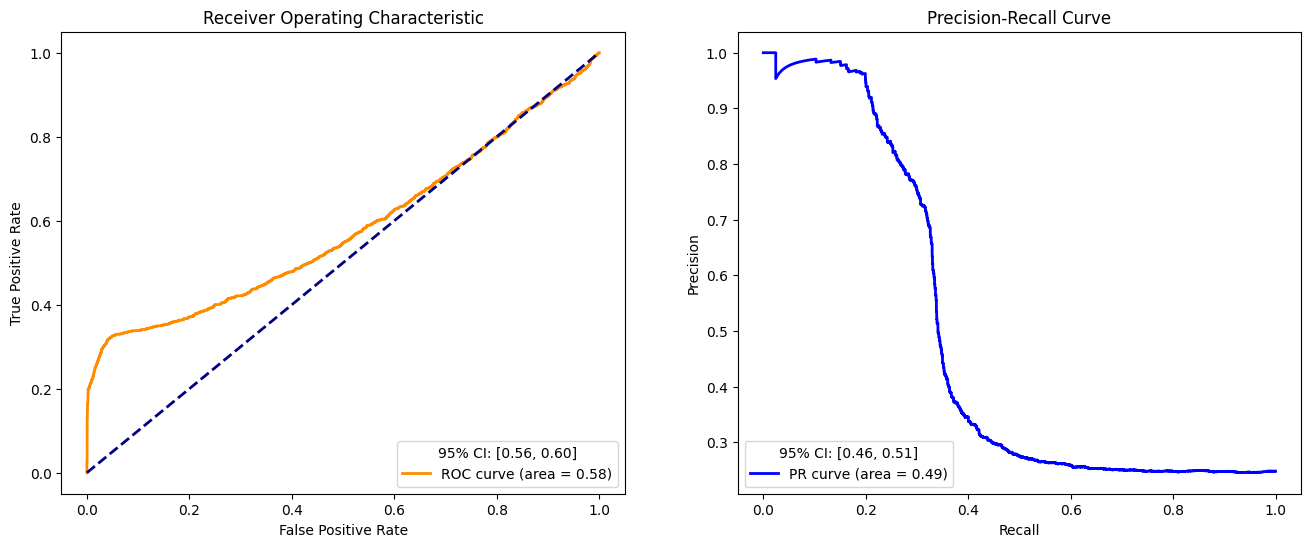

In [6]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with no regularization
auroc_confidence_interval, ap_confidence_interval = plot_roc_pr_curves(y_val, y_val_probs)

## Logistic Regression with L1 regularization

In [7]:
# Initialize the Logistic Regression model with L1 regularization
# You may need to tune the 'C' parameter using the validation set
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000, random_state=1)

# Train the model on the training set
log_reg_l1.fit(X_train, y_train)

# Predict probabilities for the validation and test sets
y_val_probs_l1 = log_reg_l1.predict_proba(X_val)[:, 1]
y_test_probs_l1 = log_reg_l1.predict_proba(X_test)[:, 1]

# Compute the AUROC and average precision score on the validation set
val_auroc = roc_auc_score(y_val, y_val_probs_l1)
val_average_precision = average_precision_score(y_val, y_val_probs_l1)

# Compute the AUROC and average precision score on the test set
test_auroc = roc_auc_score(y_test, y_test_probs_l1)
test_average_precision = average_precision_score(y_test, y_test_probs_l1)


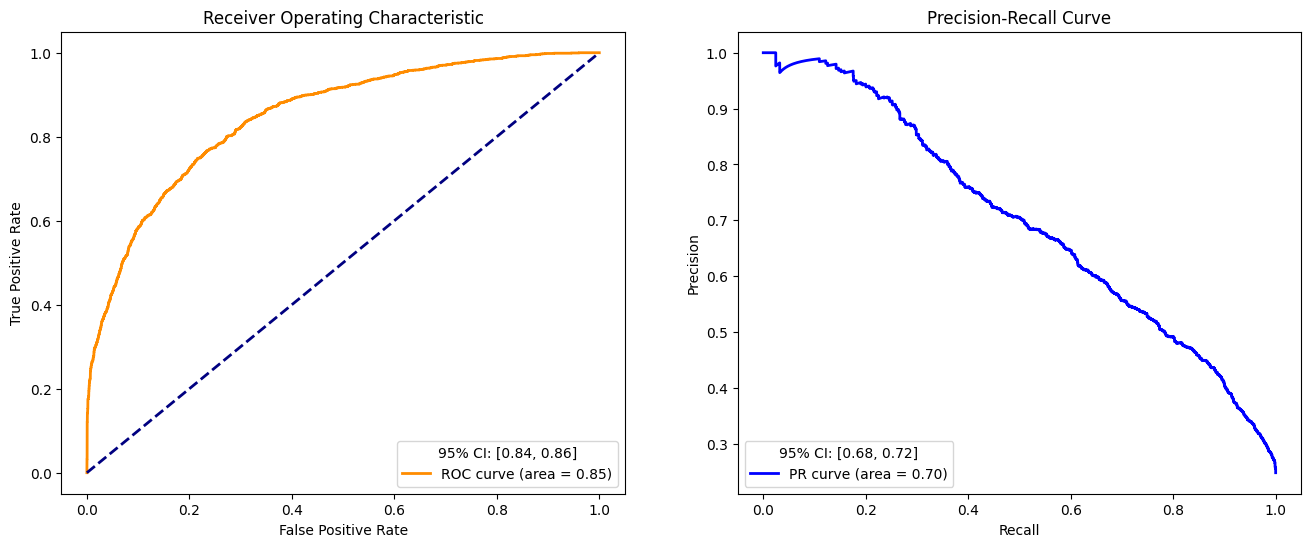

In [8]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with no regularization
auroc_confidence_interval, ap_confidence_interval = plot_roc_pr_curves(y_val, y_val_probs_l1)

## Hyperparameter tuning for C for Logistic Regression with L1 Regularization

In [9]:
# Define a set of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Initialize variables to store the best score and corresponding C value
best_score = 0
best_C = None

# Perform grid search over the C values
for C in C_values:
    # Initialize and train the Logistic Regression model with L1 regularization
    log_reg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000, random_state=1)
    log_reg_l1.fit(X_train, y_train)

    # Evaluate on the validation set
    y_val_probs = log_reg_l1.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_val_probs)

    # If the score is better than the best score, update the best score and best C
    if score > best_score:
        best_score = score
        best_C = C

# Output the best C value
print(f"Best C value: {best_C} with AUROC: {best_score:.4f}")

# Train a new model using the best C value
best_log_reg_l1 = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=1000, random_state=1)
best_log_reg_l1.fit(X_train, y_train)

# Continue with bootstrapping, plotting, and evaluation using the best_log_reg_l1 model

# Predict probabilities for the validation and test sets
y_val_probs_l1 = best_log_reg_l1.predict_proba(X_val)[:, 1]

Best C value: 0.1 with AUROC: 0.8525


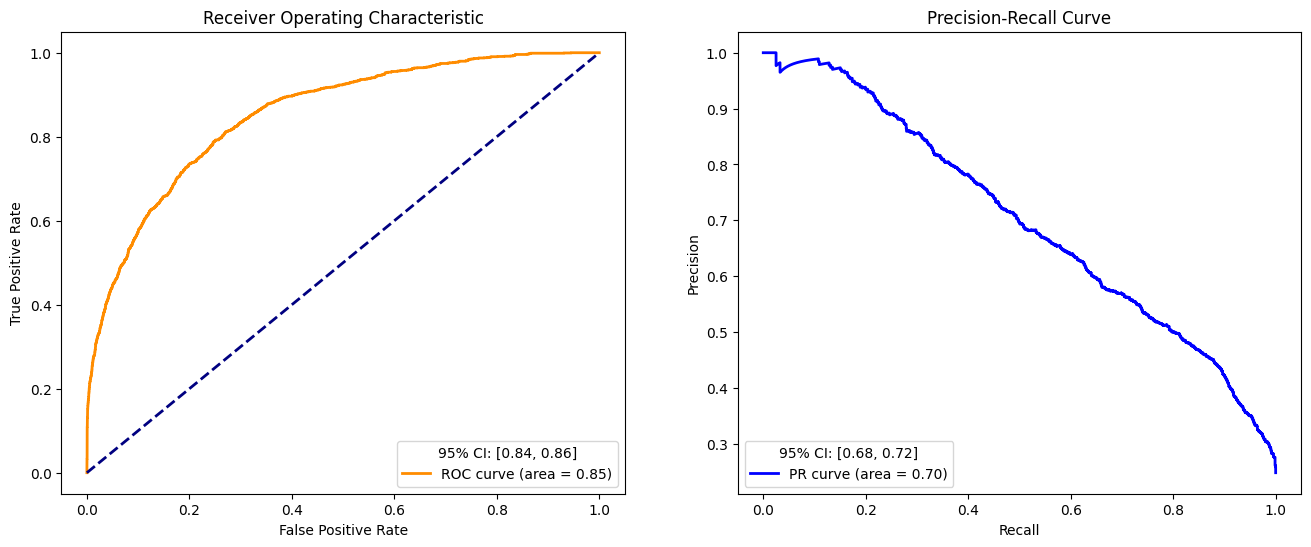

In [10]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L1 regularization
auroc_confidence_interval_l1, ap_confidence_interval_l1 = plot_roc_pr_curves(y_val, y_val_probs_l1)

## Logistic Regression with L2 regularization

In [11]:
# Define a logistic regression model. Note: The default penalty is 'l2'.
log_reg_l2 = LogisticRegression(solver='liblinear', random_state=1)

# Define the hyperparameter grid for 'C'
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Define the scoring function you want to optimize for during the grid search
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(log_reg_l2, param_grid, cv=5, scoring=scorer)

# Perform grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best C value
print(f"Best parameters: {grid_search.best_params_}")

# After grid search, the best hyperparameter value is stored in 'best_estimator_'
best_log_reg_l2 = grid_search.best_estimator_

# Now using 'best_l2_model' to make predictions and evaluate it
y_val_probs_l2 = best_log_reg_l2.predict_proba(X_val)[:, 1]

# Evaluate the model using the validation  sets
val_auroc_l2 = roc_auc_score(y_val, y_val_probs_l2)


Best parameters: {'C': 100}


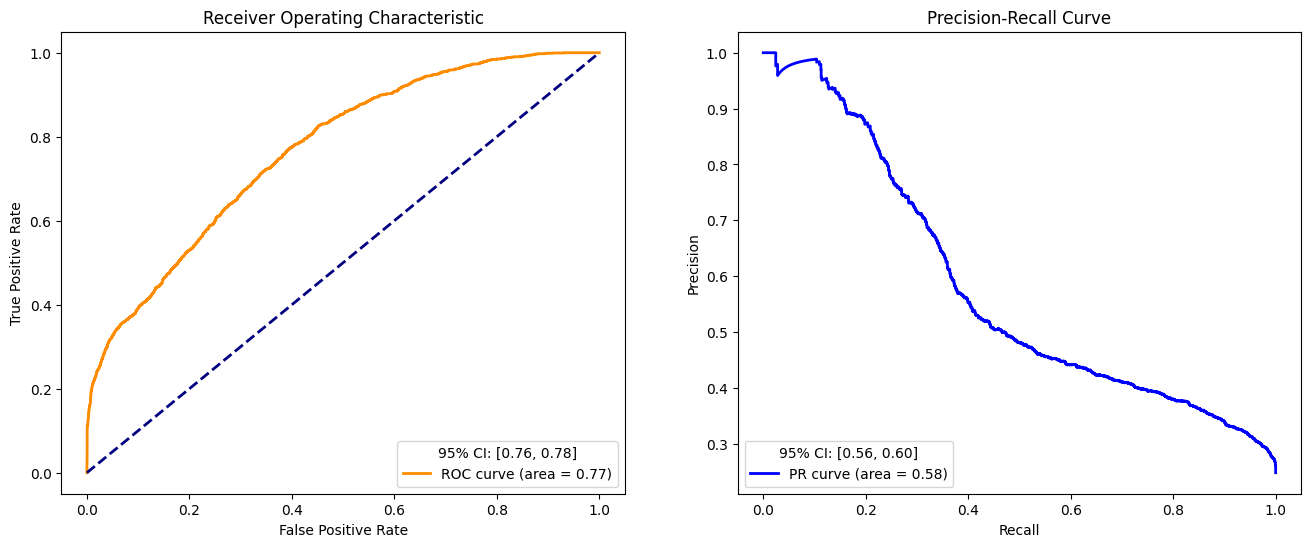

In [12]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L2 regularization after hyperparameter tuning
auroc_confidence_interval_l2, ap_confidence_interval_l2 = plot_roc_pr_curves(y_val, y_val_probs_l2)

# Final model: Logistic Regression with L1 Regularization with hyperparamter C = 0.1

In [13]:
# Predict on the test set
y_test_pred_l1 = best_log_reg_l1.predict(X_test)

# Predict probabilities on the test set
y_test_probs_l1 = best_log_reg_l1.predict_proba(X_test)[:, 1]

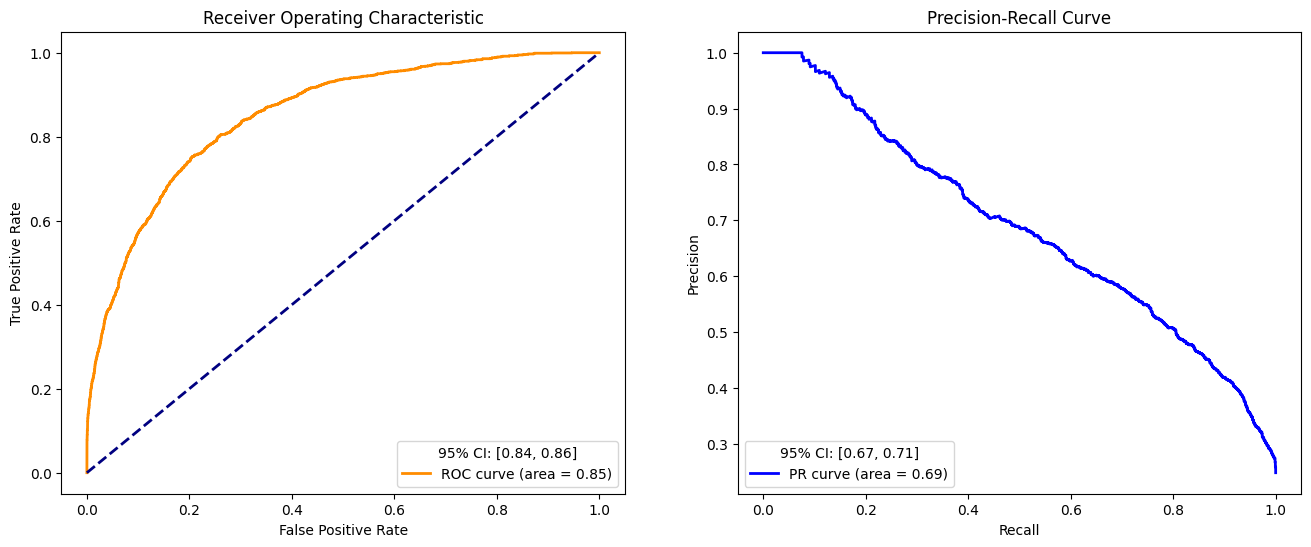

In [14]:
# AUROC and PR curves with bootstrapped 95% confidence intervals for logistic regression with L2 regularization after hyperparameter tuning on test set
auroc_confidence_interval_l1, ap_confidence_interval_l1 = plot_roc_pr_curves(y_test, y_test_probs_l1)

Test Accuracy: 0.8160
[[4805  298]
 [ 950  731]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.89      5103
           1       0.71      0.43      0.54      1681

    accuracy                           0.82      6784
   macro avg       0.77      0.69      0.71      6784
weighted avg       0.80      0.82      0.80      6784


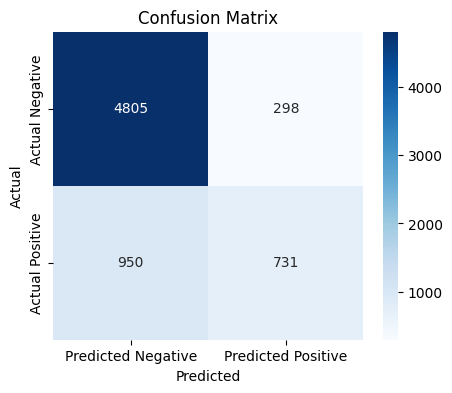

In [15]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_l1)
test_accuracy = accuracy_score(y_test, y_test_pred_l1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(cm)
print(classification_report(y_test, y_test_pred_l1))


# Plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Feature importance for Logistic Regression with L1 regularization

In [16]:
# Get the coefficients from the L1 model
log_reg_l1_coefficients = best_log_reg_l1.coef_.flatten()

# For better interpretability, look at the absolute values of the coefficients
log_reg_l1_importance = np.abs(log_reg_l1_coefficients)

importance_df = pd.DataFrame({
    'Feature': features,
    'L1 Coefficient': log_reg_l1_coefficients,
    'L1 Importance': log_reg_l1_importance,
}).sort_values('L1 Importance', ascending=False)

print(importance_df)


           Feature  L1 Coefficient  L1 Importance
9              sex    8.131102e-01   8.131102e-01
4    education-num    3.189938e-01   3.189938e-01
5   marital-status   -2.325445e-01   2.325445e-01
7     relationship   -1.662600e-01   1.662600e-01
1        workclass   -1.455624e-01   1.455624e-01
8             race    9.061556e-02   9.061556e-02
0              age    3.212019e-02   3.212019e-02
12  hours-per-week    2.680698e-02   2.680698e-02
3        education    1.115237e-02   1.115237e-02
13  native-country   -7.770493e-03   7.770493e-03
6       occupation   -4.130499e-03   4.130499e-03
11    capital-loss    6.457383e-04   6.457383e-04
10    capital-gain    2.990341e-04   2.990341e-04
2           fnlwgt    2.799795e-07   2.799795e-07
